# Augmented Reality
This is an implementation of augmented reality which uses a book cover as a marker.


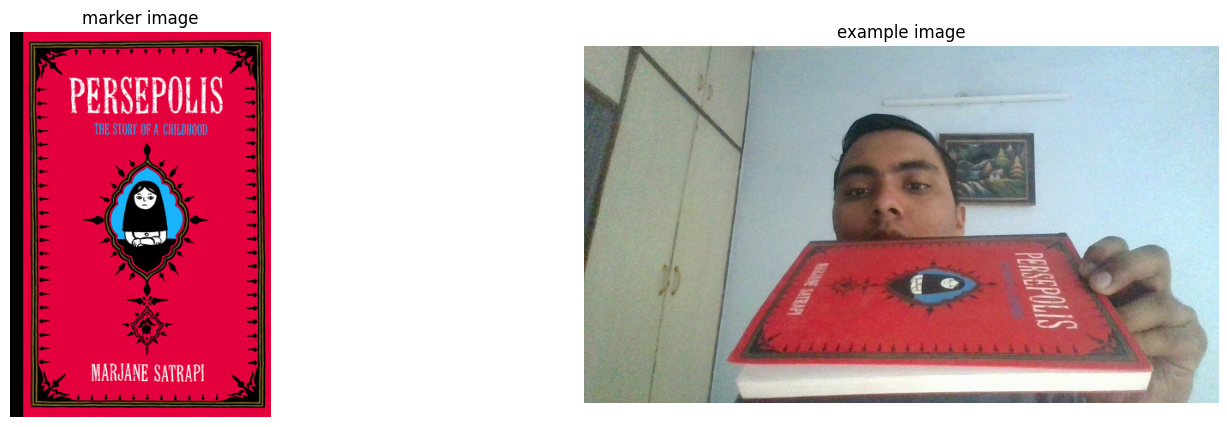

In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import math

# Read the marker image. And display for illustration purpose.
#MARKER_IMAGE = cv2.imread('mark1.jpg')
MARKER_IMAGE = cv2.imread('marker.jpg')
MARKER_IMAGE = cv2.cvtColor(MARKER_IMAGE, cv2.COLOR_BGR2RGB)

example_image = cv2.imread('ex1.jpg') # this image is used for displaying examples in this notebook
example_image = cv2.cvtColor(example_image, cv2.COLOR_BGR2RGB)

plt.figure(figsize=(18, 5))
plt.subplot(1, 2, 1)
plt.axis("off")
plt.imshow(MARKER_IMAGE)
plt.title('marker image')

plt.subplot(1, 2, 2)
plt.axis("off")
plt.imshow(example_image)
plt.title('example image')
plt.show()

# Find the marker in each frame: Feature Detection, Description and Matching

## 1. Feature Detection and Description
Using SIFT algorithm for feature detection and description. https://docs.opencv.org/3.4/da/df5/tutorial_py_sift_intro.html

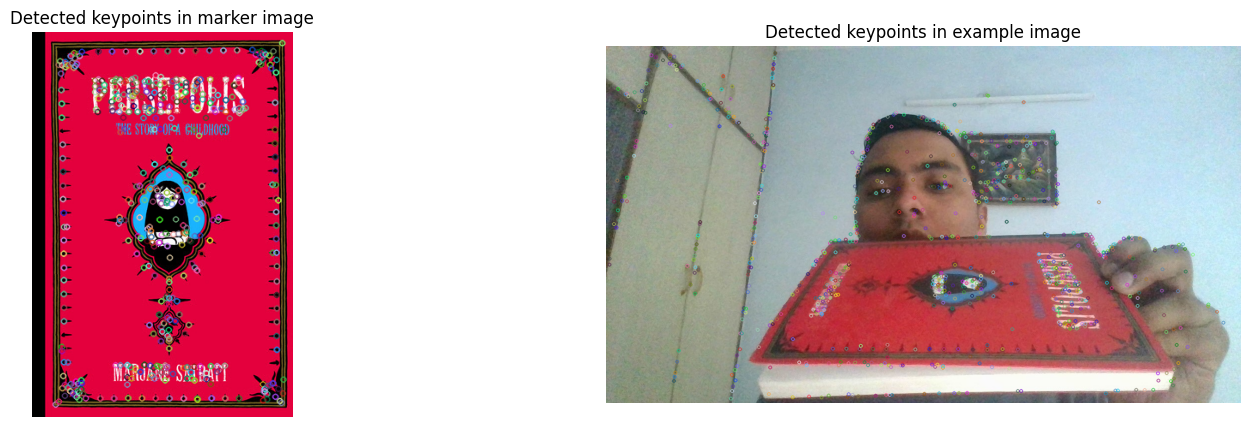

In [2]:
sift = cv2.SIFT_create()


def FEATURE_DETECTION_AND_DESCRIPTION(image):
    keypoints, descriptors = sift.detectAndCompute(image, None)
    return keypoints, descriptors, cv2.drawKeypoints(image, keypoints, image)


MARKER_KP, MARKER_DESC, marker_image_with_key_points = FEATURE_DETECTION_AND_DESCRIPTION(MARKER_IMAGE)
example_kp, example_desc, example_image_with_key_points = FEATURE_DETECTION_AND_DESCRIPTION(example_image)

# plotting the detected keypoints in marker and example image.
plt.figure(figsize=(18, 5))
plt.subplot(1, 2, 1)
plt.axis("off")
plt.imshow(marker_image_with_key_points)
plt.title("Detected keypoints in marker image")

plt.subplot(1, 2, 2)
plt.axis("off")
plt.imshow(example_image_with_key_points)
plt.title("Detected keypoints in example image")
plt.show()

## 2. Feature Matching
Using Brute-Force matching; https://docs.opencv.org/3.4/dc/dc3/tutorial_py_matcher.html.
BFMatcher() uses a distance metric, and thresholding.

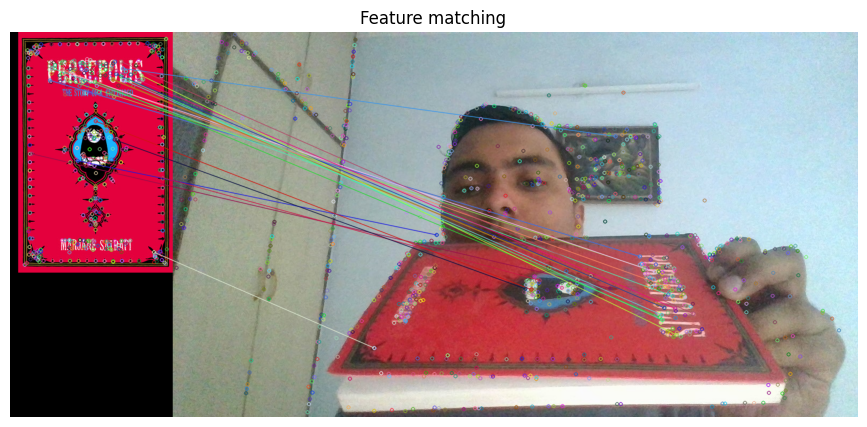

In [3]:
bf = cv2.BFMatcher()

def FEATURE_MATCHING(image, image_desc):
    matches = bf.knnMatch(MARKER_DESC, image_desc, k=2)
    # Apply ratio test
    good = []
    for m,n in matches:
        if m.distance < 0.75*n.distance:
            good.append(m)
    return good



example_matches = FEATURE_MATCHING(example_image, example_desc) # match features of the example image with the marker image, for illustration.

matched_image_ref = cv2.drawMatchesKnn(MARKER_IMAGE, MARKER_KP, example_image, example_kp, np.reshape(example_matches, (-1,1)), 0, flags=2)
plt.figure(figsize=(18, 5))
plt.axis('off')
plt.imshow(matched_image_ref)
plt.title('Feature matching')
plt.show() # notice that outliers are also matched.






# Finding Homography matrix
Code adapted from https://docs.opencv.org/3.4/d1/de0/tutorial_py_feature_homography.html.
Using the RANSAC algorithm.

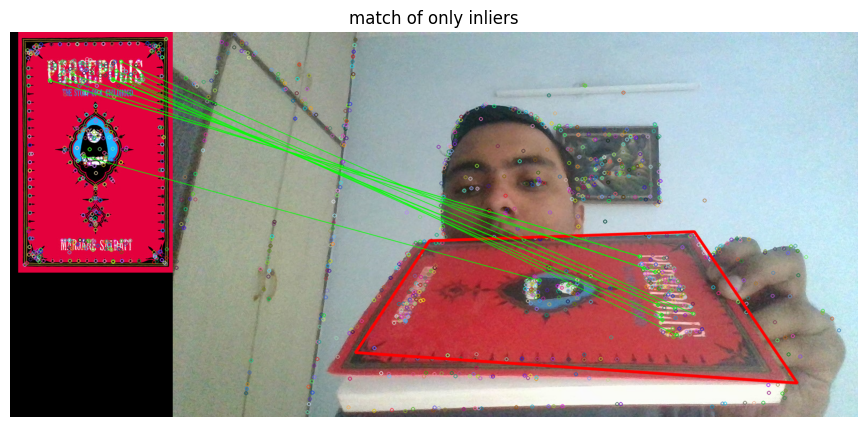

In [4]:
def HOMOGRAPHY(image, image_kp, image_desc, image_matches):
    marker_pts = np.float32([MARKER_KP[m.queryIdx].pt for m in image_matches]).reshape(-1, 1, 2) 
    image_pts = np.float32([image_kp[m.trainIdx].pt for m in image_matches]).reshape(-1, 1, 2)
        
    M, mask = cv2.findHomography(marker_pts, image_pts, cv2.RANSAC, 5.0) # finds the perspective transform of the marker
    matchesMask = mask.ravel().tolist()
        
    h, w, _ = MARKER_IMAGE.shape
    pts = np.float32([[0, 0], [0, h-1], [w-1, h-1], [w-1, 0]]).reshape(-1, 1, 2)
    
    if M is not None:
        dst = cv2.perspectiveTransform(pts, M) # From tutorial link above: Needs at least 4 correct points to find transformation.   
        image = cv2.polylines(image, [np.int32(dst)], True, 255, 3, cv2.LINE_AA)
    
    return M, matchesMask, image



# Finding homography matrix M and inliers for the example image
M, matchesMask, tempframe = HOMOGRAPHY(example_image, example_kp, example_desc, example_matches)
# draw the inliers for the example image
draw_params = dict(matchColor = (0, 255, 0), singlePointColor = None, matchesMask = matchesMask, # draw only inliers
                   flags = 2)
                   

inlier_matched_image = cv2.drawMatches(MARKER_IMAGE, MARKER_KP, example_image, example_kp, example_matches, None, **draw_params)
plt.figure(figsize=(18, 5))
plt.axis('off')
plt.imshow(inlier_matched_image)
plt.title('match of only inliers')
plt.show()

# Estimating pose of marker in each frame
Code for estimating pose adapted from:
https://docs.opencv.org/4.x/d9/dab/tutorial_homography.html#pose_ar.

In [7]:
#camera_parameters = np.array([[800, 0, 320], [0, 800, 240], [0, 0, 1]])
camera_parameters = [[777.77229437, 0, 622.14282285],
                     [ 0, 774.3453775, 362.60599864],
                     [ 0, 0, 1]]
def estimate_pose(image, H): # H = Homography matrix 
    _H = np.array(H) * (-1)
    P = np.linalg.inv(camera_parameters) @ _H
    norm = ((P[0][0]**2) + (P[1][0]**2) + (P[2][0]**2)) ** (0.5)
    
    P /= norm
    r1  = P[:, 0]
    r2  = P[:, 1]
    r3 = np.cross(r1, r2) # since the rotation matrix is orthonormal, its 3rd column can be calculated as cross-product of first & second columns.
    tvec = P[:, 2]
    P = np.stack([r1, r2, r3, tvec]).T
    
    return camera_parameters @ P


# Place object on the marker plane
The place_object() function below directly taken from https://github.com/juangallostra/augmented-reality/blob/master/src/ar_main.py

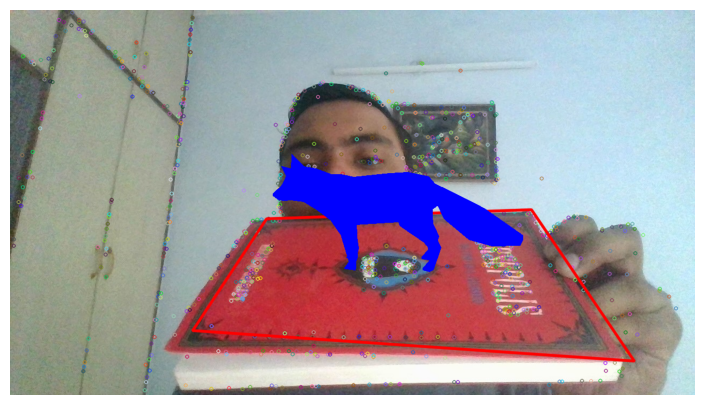

In [13]:
import objloader as obj

OBJECT = obj.OBJ("Model/low-poly-fox-by-pixelmannen.obj", swapyz=True)

def place_object(img, obj, projection, scale3d = 8, color=False):
    vertices = obj.vertices
    scale_matrix = np.eye(3) * scale3d
    h, w, z = MARKER_IMAGE.shape

    for face in obj.faces:
        face_vertices = face[0]
        points = np.array([vertices[vertex - 1] for vertex in face_vertices])
        points = points @ scale_matrix
        points = np.array([[p[0] + w / 2, p[1] + h / 2, p[2]] for p in points])
        dst = cv2.perspectiveTransform(points.reshape(-1, 1, 3), projection)
        imgpts = np.int32(dst)

        cv2.fillConvexPoly(img, imgpts, (0, 0, 255))
    return img



render_img = place_object(tempframe, OBJECT, estimate_pose(tempframe, M), 2, True)
plt.figure(figsize=(10, 5))
plt.axis('off')
plt.imshow(render_img)
plt.show()

# Open the live camera using OpenCV; read each frame.
How to read frames from live camera; https://docs.opencv.org/3.4/dd/d43/tutorial_py_video_display.html

In [15]:
threshold_num_matches =20 # minimum number of matches required so that further processing can be done.

camera = cv2.VideoCapture(0)

if not camera.isOpened():
    print("Cannot open camera")
    exit()

while True:
    # Capture camera frame-by-frame
    ret, frame = camera.read()
    
    if ret == False:
        print("Stream ended. Abort.")
        break
    
    # feature detection and description of each frame
    kp, desc, frame_with_kps = FEATURE_DETECTION_AND_DESCRIPTION(frame)
    
    # match features with the marker image.
    matches = FEATURE_MATCHING(frame, desc)
   
    if len(matches) <= threshold_num_matches:
        cv2.imshow("augmented reality program", frame)
    
    else:
        # finding homography matrix H
        H, _, newFrame = HOMOGRAPHY(frame, kp, desc, matches)
        
        if H is not None:
            # estimating the projection matrix
            projMatrix = estimate_pose(frame, H)
            cv2.imshow("augmented reality program", place_object(newFrame, OBJECT, projMatrix, 2, True))
        
        else:
            cv2.imshow("augmented reality program", frame)

    if cv2.waitKey(1) == ord('q'):
        break


camera.release()
cv2.destroyAllWindows()